## Irony Detection in English Tweets with Neural Network ##

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import demoji
#demoji.download_codes()
from nltk.tokenize import TweetTokenizer
from argparse import Namespace
from collections import Counter
import json
import os
import string
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Task A: Binary Classfication of tweets as Ironic/Non-Ironic ###

#### Data Preparation ####

In [ ]:
'''
1) Replace emojis with :text:
2) Replace @user
3) Replace url
'''

In [ ]:
taskA_train_file = "./data/taskA/train_emoji.txt"
taskA_test_file = "./data/taskA/test_emoji.txt"

In [ ]:
with open(taskA_train_file, 'r') as f:
    train_lines = [line.split('\t') for line in f.readlines()][1:]
assert len(train_lines) == 3834
with open(taskA_test_file, 'r') as f:
    test_lines = [line.split('\t') for line in f.readlines()][1:]
assert len(test_lines) == 784

In [ ]:
taskA_train = pd.DataFrame(train_lines, columns = ['Tweet index', 'label', 'Tweet text'])
taskA_test = pd.DataFrame(test_lines, columns = ['Tweet index', 'label', 'Tweet text'])

In [ ]:
# display full cell of dataframe
pd.set_option('display.max_colwidth', -1)

In [ ]:
taskA_train.head(1)

In [ ]:
taskA_test.head(1)

In [ ]:
# tokenize
tokenizer = TweetTokenizer()
# test
tweet = "I asked God to protect me from my enemies .. shortly after I started losing friends 😳💯  or #naah"
print(tokenizer.tokenize(tweet))

In [ ]:
# get full vocab for training data
vocab = set(tokenizer.tokenize(' '.join(taskA_train['Tweet text'])))
# sort vocab
vocab = sorted(vocab)
print("Vocab size: ", len(vocab))
#print(vocab)

In [ ]:
# inspect vocabulary
# urls, hashtag, usertag, number, punctuation
urls = [token for token in vocab if 'http' in token]
print("Number of urls: {}".format(len(urls)))
vocab_tmp = list(set(vocab) - set(urls))
# hashtags
hashtags = [token for token in vocab_tmp if '#' in token]
print("Number of hashtags: {}".format(len(hashtags)))
vocab_tmp = list(set(vocab_tmp) - set(hashtags))
# emojis
emojis = demoji.findall(' '.join(vocab_tmp))
print("Number of emojis: {}".format(len(emojis)))
#print(emojis)
vocab_tmp = list(set(vocab_tmp) - set(emojis))
usertag = [token for token in vocab_tmp if '@' in token]
print("Number of usertag: {}".format(len(usertag)))
vocab_tmp = list(set(vocab_tmp) - set(usertag))
# numbers 
alphanumeric = vocab_tmp
print("Number of alphanumeric and punctuations: {}".format(len(alphanumeric)))

In [ ]:
'''
All urls will take the [URL] token
All usertag will take the [USER] token
All emojis will be translated to text surrounded by :
    examples, 💯 will be :hundred points:
alphanumeric and puntuations will be left as they are
'''
# preprocess function that make the above adjustments to tweet text
def preprocess(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    emojis = demoji.findall(text)
    cleaned = []
    for token in tokens:
        if 'http' in token:
            cleaned.append('[URL]')
        elif '@' in token:
            cleaned.append('[USER]')
        elif token in emojis:
            cleaned.append(':' + ''.join(emojis[token].split()) + ':')
        else:
            cleaned.append(token.lower())
    return ' '.join(cleaned)

In [ ]:
cleaned_train = taskA_train['Tweet text'].map(preprocess)
cleaned_test = taskA_test['Tweet text'].map(preprocess)

In [ ]:
taskA_train['Tweet text'] = cleaned_train
taskA_test['Tweet text'] = cleaned_test
taskA_train.to_csv('./preprocessed/taskA/train.csv', header = True, index = False)
taskA_test.to_csv('./preprocessed/taskA/test.csv', header = True, index = False)


In [ ]:
# write vocab file
vocab = set(tokenizer.tokenize(' '.join(taskA_train['Tweet text'])))
# sort vocab
vocab = sorted(vocab)
print("Vocab size: ", len(vocab))
#print(vocab)
with open('./preprocessed/taskA/vocab.txt', 'w') as f:
    for token in sorted(vocab):
        f.write(token + '\n')

In [ ]:
# write vocab file for preprocessed dataset
preprocessed_data = pd.read_csv("./preprocessed/taskA/train_taskA.csv")
vocab = sorted(list(set(' '.join(preprocessed_data['Tweet text']).split())))
print(len(vocab))
# write to preprocessed_vocab.txt
with open("./preprocessed/taskA/preprocessed_vocab.txt", 'w') as f:
    for word in vocab:
        f.write(word + '\n')

In [ ]:
# Replace Emojis with text #
# test
#tweet = "@TargetZonePT 😡 no he bloody isn't I was upstairs getting changed !"
tweet = "I asked God to protect me from my enemies .. shortly after I started losing friends 😳💯  or #naah"
demoji.findall(tweet)

#### Model: Classifying Tweets as Ironic/Non-Ironic with a Neural Network ####

In [33]:
'''
Reference: 
Natural Language Processing with PyTorch
Delip Rao & Brian McMahan
'''
# train.csv is preprocessed by teammate with 17 tweets with 0 label removed
# it facilitates 5-fold cross validation
df = pd.read_csv("./preprocessed/taskA/train_taskA.csv")
print(len(df))
df.columns

3000


Index(['Tweet index', 'label', 'Tweet text'], dtype='object')

In [34]:
def get_train_val_split(infile, seed = 1):
    folds = {}
    random.seed(seed)
    # create a dictionary partition
    # partition['train']: list of training IDs
    # partition['validation']: list of validation IDs
    length = len(pd.read_csv(infile))
    indices = list(range(length))
    random.shuffle(indices)
    one_fold = length // 5
    for i in range(1, 6):
        curr_dict = {}
        curr_dict['validation'] = indices[one_fold * (i - 1) : one_fold * i]
        curr_dict['train'] = list(set(indices) - set(curr_dict['validation']))
        folds[i] = curr_dict
    return folds

In [184]:
vocab = {}
def build_vocab(infile, fold, vocab_size = 1000):
    global vocab
    vocab = {}
    freq_dict = {}
    df = pd.read_csv(infile)
    df = df.iloc[fold['train'],:]
    # concat all tweets into one string
    tweets_string = ' '.join(df['Tweet text'])
    # remove punctuation, convert to lower case
    processed_tweets_string = re.sub(r'[^\w\s]', ' ', tweets_string).lower()
    # split into tokens
    tokens = processed_tweets_string.split()
    # create count dictionary freq_dict
    for token in tokens:
        if token in freq_dict:
            freq_dict[token] += 1
        else:
            freq_dict[token] = 1
    # sort dictionary in descending freq count
    sorted_freq = sorted(freq_dict.items(), key = lambda x:x[1], reverse = True)
    # take top vocab_size - 1 vocab, accounting for [UNK] token
    pruned_vocab = sorted_freq[:vocab_size - 1]
    # add to vocab
    vocab['[UNK]'] = 0
    for i, token_tuple in enumerate(pruned_vocab):
        vocab[token_tuple[0]] = i + 1
    return

In [36]:
def vectorizer(infile, vocab_size = 1000):
    vectors = {}
    labels = {}
    df = pd.read_csv(infile)
    for index, row in df.iterrows():
        vec = [0] * vocab_size
        tokens = list(set(re.sub(r'[^\w\s]', ' ', row['Tweet text']).lower().split()))
        for token in tokens:
            if token in vocab:
                vec[vocab[token]] = 1
            else:
                vec[0] = 1
        vectors[index] = vec
        labels[index] = int(row['label'])
    return (vectors, labels)

In [37]:
import torch
from torch.utils import data
class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        # generates one sample of data
        ID = self.list_IDs[index]
        X = torch.tensor(vectors[ID])
        y = self.labels[ID]
        return X, y

In [38]:
''' Model '''
class IronyClassifier(nn.Module):
    ''' A 2-layer Multilayer Perceptron for classifying tweets '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        '''
        Args:
            input_dim (int): size of input vector(size of vocab)
            hidden_dim (int): output size of the first linear layer
            output_dim (int): output size of the second linear layer(number of classes)
        '''
        super(IronyClassifier, self).__init__()
        # fully connected layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    ''' Forward propogation of the classifier '''    
    def forward(self, x_in, apply_softmax = False):
        '''
        Args: 
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for softmax activation
                should be false if using Cross Entropy Loss
        Returns:
            result tensor. tensor.shape should be (batch, output_dim)
        '''
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)
        
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim = 1)
            
        return prediction_vector
    

In [39]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices)

In [40]:
data_file = "./preprocessed/taskA/train_taskA.csv"

In [189]:
args = Namespace(
    # Training  hyper parameters
    vocab_size = 1000,
    num_epochs = 20,
    hidden_dim = 3,
    learning_rate = 0.0002,
    batch_size = 32,
)

In [190]:
# 5-fold cross validation
# get the indices for train and validation for each fold
global vectors, labels
folds = get_train_val_split(data_file)
fold = 1
partition = folds[fold]
assert len(partition['train']) == 2400
assert len(partition['validation']) == 600
# create vocab
build_vocab(data_file, partition, vocab_size = args.vocab_size)
print(len(vocab))
assert len(vocab) == args.vocab_size
# create vectors and labels
vectors, labels = vectorizer(data_file, vocab_size = args.vocab_size)
# training loop

training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, batch_size = args.batch_size, shuffle = True)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, batch_size = args.batch_size, shuffle = True)


1000


In [193]:
# training loop
device = 'cpu'
classifier = IronyClassifier(input_dim = args.vocab_size, hidden_dim = args.hidden_dim, output_dim = 2)
classifier = classifier.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr = args.learning_rate)

for epoch in range(args.num_epochs):
    # training
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()
    batch_index = 0
    for local_batch, local_labels in training_generator:
        # clear gradients
        optimizer.zero_grad()
        # compute output
        y_pred = classifier(local_batch.float())
        # compute loss
        loss = loss_func(y_pred, local_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)
        # produce gradients
        loss.backward()
        # backpropogation
        optimizer.step()
        # compute accuracy
        acc_t = compute_accuracy(y_pred, local_labels)
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        batch_index += 1
    print("Epoch {}: ".format(epoch + 1))
    print("  Train Loss: {}".format(running_loss))
    print("  Train Accuracy: {}".format(running_acc))     

Epoch 1: 
  Train Loss: 0.705472398598989
  Train Accuracy: 0.4920833333333334
Epoch 2: 
  Train Loss: 0.7018710390726727
  Train Accuracy: 0.4920833333333332
Epoch 3: 
  Train Loss: 0.6978029433886213
  Train Accuracy: 0.4920833333333333
Epoch 4: 
  Train Loss: 0.6935439046223958
  Train Accuracy: 0.4920833333333332
Epoch 5: 
  Train Loss: 0.6889973974227905
  Train Accuracy: 0.49416666666666664
Epoch 6: 
  Train Loss: 0.6838646944363911
  Train Accuracy: 0.5166666666666666
Epoch 7: 
  Train Loss: 0.6780102411905925
  Train Accuracy: 0.5587500000000001
Epoch 8: 
  Train Loss: 0.6715598702430724
  Train Accuracy: 0.61875
Epoch 9: 
  Train Loss: 0.6645601320266724
  Train Accuracy: 0.6608333333333333
Epoch 10: 
  Train Loss: 0.657290608882904
  Train Accuracy: 0.69125
Epoch 11: 
  Train Loss: 0.6497125943501793
  Train Accuracy: 0.7108333333333335
Epoch 12: 
  Train Loss: 0.6419802618026734
  Train Accuracy: 0.7175
Epoch 13: 
  Train Loss: 0.6342303967475892
  Train Accuracy: 0.72333333

In [194]:
running_loss = 0.0
running_acc = 0.0
classifier.eval()
batch_index = 0
with torch.set_grad_enabled(False):
    for local_batch, local_labels in validation_generator:
        # get prediction
        y_pred =  classifier(local_batch.float())
        loss = loss_func(y_pred, local_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)
        # compute accuracy
        acc_t = compute_accuracy(y_pred, local_labels)
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        batch_index += 1
    print("  Val Loss: {}".format(running_loss))
    print("  Val Accuracy: {}".format(running_acc))

  Val Loss: 0.6476331164962368
  Val Accuracy: 0.6337719298245613


#### Hyperparameter Tuning with 5-fold Cross Validation ####

In [89]:
'''
Hyperparameters:
    vocab_size
    num_epochs
    hidden_dim
    learning_rate
    batch_size
'''
def plot_accuracy(x, y, z, title, xlabel, ylabel):
    fig = plt.figure()
    test, = plt.plot(x, y, marker = 'o', color = 'royalblue', linestyle = '--')
    train, = plt.plot(x, z, marker = 'o', color = 'coral', linestyle = '--')
    plt.legend([test, train], ["test", "train"])
    plt.grid(color='mediumpurple', linestyle='--', alpha = 0.5)
    fig.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return

In [27]:
##### Vocab Size #####

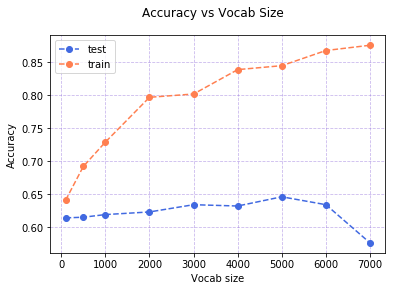

In [195]:
# num_epochs = 20
# hidden_dim = 3
# learning_rate = 0.0002
# batch_size = 32
x = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
# test accuracy
y = [0.614, 0.615, 0.619, 0.623, 0.634, 0.632, 0.646, 0.634, 0.576]
# train accuracy
z = [0.641, 0.692, 0.729, 0.797, 0.802, 0.839, 0.845, 0.868, 0.876]
plot_accuracy(x, y, z, "Accuracy vs Vocab Size", "Vocab size", "Accuracy")

